# Simple Hedging Example

This notebook works through all the steps of this hedging strategy applied to the S&P 500 index.

The strategy follows the steps below:

1. Use 3 month of historical data to estimate the parameters of the model via Baysian inference an probabilistic programming. Use this to estimate the future distribution at a later time time $T$ over the S&P 500 index.
2. Using teh estimate distribution, construct a portfolio of short/long put/call options to ensure a flat distribution over a fixed range of the expected distribution
3. Use the Kelly Criterion to determine the optimal amount of capital to allocate to the portfolio

### Some critical assumptions
We will assume that the evolution of the S&P 500 index over a short period of time obeys a geometric Brownian motion SDE with constant parameters
 $$d\log (S_t) = \left(\mu - \frac{\sigma^{2}}{2}\right)dt + \sigma dW_t$$

In [1]:
import numpy as np
import datetime as dt

from _fitting import *
from _utils import *

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_98312/2676093710.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [181]:
# Set ticker
ticker = "^GSPC"
# ticker = "AAPL"

# set date range
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2022, 6, 1)

# interval
interval = "1h"

# Get the data
data = get_stock_data(ticker, start_date, end_date, interval=interval)

# Compute log price and add days
data['log_close'] = np.log(data['Adj Close'])
data['days'] = (data.index - data.index[0]).days

#---------------------#
Getting underlying data for ticker:  ^GSPC
#---------------------#
[*********************100%***********************]  1 of 1 completed


In [182]:
# Get some rough estimates of mu and sigma
mu, sigma = estimate_coeffs(data['log_close'], len(data['log_close']), 1)

print("mu: ", mu)
print("sigma: ", sigma)

mu:  -0.0001879458560943359
sigma:  0.005480660482023212


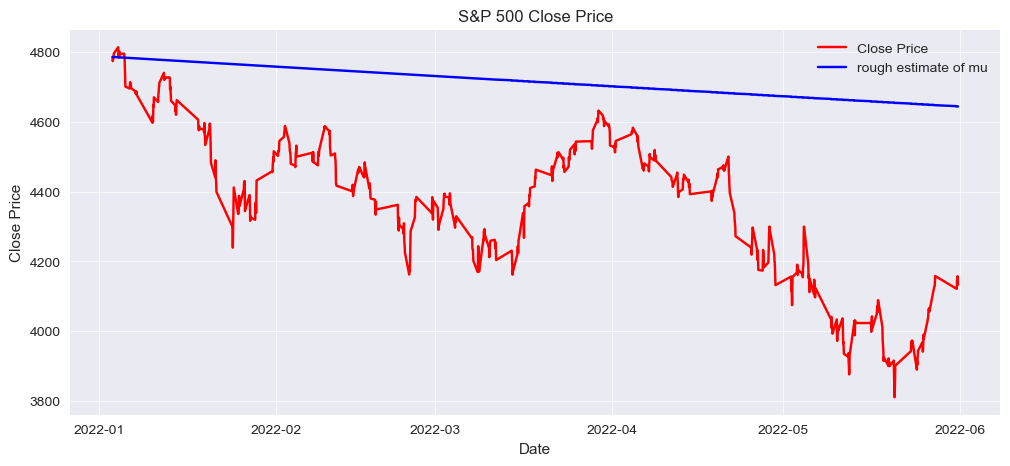

In [183]:
fig = plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Close"], color='r', label="Close Price")

# Plot mu as a straight line with the date range
plt.plot(data.index, np.exp(data['log_close'][0] + (mu - 0.5* sigma**2) * data['days']), color='b', label="rough estimate of mu")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("S&P 500 Close Price")
plt.grid(linestyle='-', linewidth=0.5)
plt.legend()

plt.show()

In [184]:
# We now fit the geometric brownian motion model to the data
trace = fit_geometric_brownian_motion(data['Close'].values, [mu, np.abs(mu), sigma], 1)

/Users/michael/miniconda3/lib/python3.10/site-packages/pymc/distributions/timeseries.py:973: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, stock]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


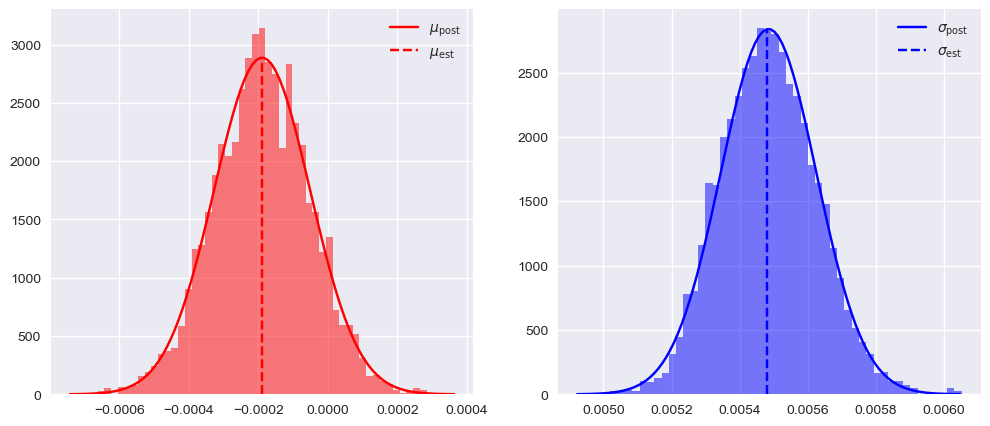

In [185]:
# Plot the trace estimates of the posterior distribution
mu_post = trace.posterior.get("mu").values.flatten()
sigma_post = trace.posterior.get("sigma").values.flatten()

# Get the pdfs of posterieor distributions
mu_pdf_x, mu_pdf = normal_pdf(mu_post)
sigma_pdf_x, sigma_pdf = normal_pdf(sigma_post)

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mu_pdf_x, mu_pdf, color='r', label=r"$\mu_{\rm post}$")
plt.vlines(mu, 0, np.max(mu_pdf), color='r', linestyle='--', label=r"$\mu_{\rm est}$")
plt.hist(mu_post, bins=50, density=True, alpha=0.5, color='r')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma_pdf_x, sigma_pdf, color='b', label=r"$\sigma_{\rm post}$")
plt.vlines(sigma, 0, np.max(sigma_pdf), color='b', linestyle='--', label=r"$\sigma_{\rm est}$")
plt.hist(sigma_post, bins=50, density=True, alpha=0.5, color='b')
plt.legend()

plt.show()

In [204]:
# We can now infer the future probability distribution of the stock price using bayesian inference
# Future time we are inetrested in 
T = 7

s_range = [data['Close'].values[-1]*0.94, data['Close'].values[-1]*1.1]
s, s_est = infer_stock_pdf(mu_post, sigma_post, data['Close'].values[-1], T, s_range, ds=1)


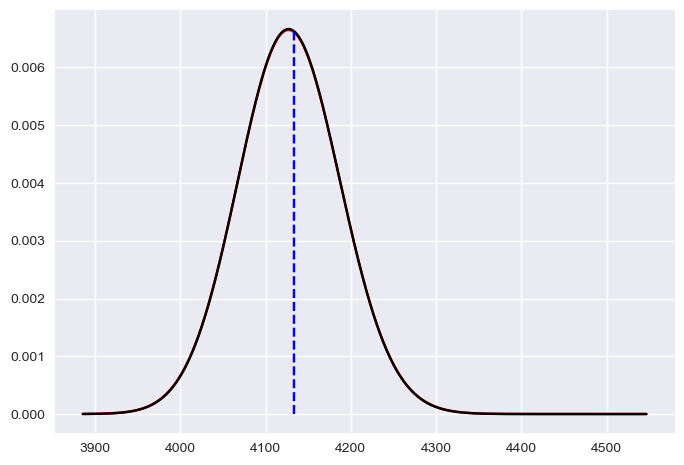

In [205]:
# Plot the posterior distribution
plt.plot(s, s_est, color='r', label="Posterior Distribution")
plt.plot(s, stock_pdf(s, data['Close'].values[-1], T, mu, sigma), color='k', label="Naive Distribution")
plt.vlines(data['Close'].values[-1], 0, np.max(s_est), color='b', linestyle='--', label="Current Price")